In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
EPOCHS = 25
INIT_LR = 0.01
BS = 100
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'C://Users//acer//Desktop//New Researchers//Kaggle//Tomato//New Plant Diseases Dataset(Augmented)//New Plant Diseases Dataset(Augmented)/'
width=256
height=256
depth=3

In [ ]:
from keras.applications import VGG16

In [ ]:
# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 

#Loads the VGG16 model 
model = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
model.input

<tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>

In [ ]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 10

FC_Head = addTopModel(model, num_classes)

modelnew = Model(inputs=model.input, outputs=FC_Head)

print(modelnew.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'C://Users//acer//Desktop//New Researchers//Kaggle//Tomato//New Plant Diseases Dataset(Augmented)//train'
validation_data_dir = 'C://Users//acer//Desktop//New Researchers//Kaggle//Tomato//New Plant Diseases Dataset(Augmented)//valid'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 16
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
                   
checkpoint = ModelCheckpoint("vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate 
modelnew.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 1190
nb_validation_samples = 170
epochs = 10
batch_size = 16

history = modelnew.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

modelnew.save("vgg.h5")

Epoch 1/10
74/74 [==============================] - 646s 9s/step - loss: 2.8709 - accuracy: 0.1520 - val_loss: 1.3982 - val_accuracy: 0.8300

Epoch 00001: val_loss improved from inf to 1.39816, saving model to flowers_vgg.h5
Epoch 2/10
74/74 [==============================] - 548s 7s/step - loss: 1.9133 - accuracy: 0.3041 - val_loss: 0.1423 - val_accuracy: 0.9700

Epoch 00002: val_loss improved from 1.39816 to 0.14227, saving model to flowers_vgg.h5
Epoch 3/10
74/74 [==============================] - 512s 7s/step - loss: 1.6227 - accuracy: 0.4316 - val_loss: 0.3612 - val_accuracy: 0.8700

Epoch 00003: val_loss did not improve from 0.14227
Epoch 4/10
74/74 [==============================] - 530s 7s/step - loss: 1.4829 - accuracy: 0.4780 - val_loss: 0.2407 - val_accuracy: 0.9400

Epoch 00004: val_loss did not improve from 0.14227
Epoch 5/10
74/74 [==============================] - 524s 7s/step - loss: 1.2893 - accuracy: 0.5405 - val_loss: 1.8395 - val_accuracy: 0.4500
Restoring model wei

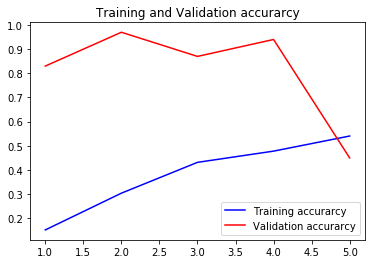

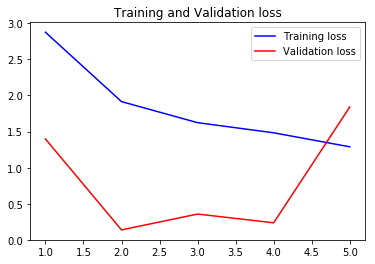

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

In [ ]:
from keras.models import load_model

classifier = load_model('vgg.h5')

In [ ]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

monkey_breeds_dict = {"[0]": "Tomato___Bacterial_spot ", 
                      "[1]": "Tomato___Early_blight",
                      "[2]": "Tomato___healthy",
                      "[3]": "Tomato___Late_blight",
                      "[4]": "Tomato___Leaf_Mold ",
                      "[5]": "Tomato___Septoria_leaf_spot",
                      "[6]": "Tomato___Spider_mites Two-spotted_spider_mite",
                      "[7]": "Tomato___Target_Spot",
                      "[8]": "Tomato___Tomato_mosaic_virus",
                      "[9]": "Tomato___Tomato_Yellow_Leaf_Curl_Virus"}

monkey_breeds_dict_n = {"Tomato___Bacterial_spot": "Tomato___Bacterial_spot ", 
                      "Tomato___Early_blight": "Tomato___Early_blight",
                      "Tomato___healthy": "Tomato___healthy",
                      "Tomato___Late_blight": "Tomato___Late_blight",
                      "Tomato___Leaf_Mold": "Tomato___Leaf_Mold ",
                      "Tomato___Septoria_leaf_spot": "Tomato___Septoria_leaf_spot",
                      "Tomato___Spider_mites Two-spotted_spider_mite": "Tomato___Spider_mites Two-spotted_spider_mite",
                      "Tomato___Target_Spot": "Tomato___Target_Spot",
                      "Tomato___Tomato_mosaic_virus": "Tomato___Tomato_mosaic_virus",
                      "Tomato___Tomato_Yellow_Leaf_Curl_Virus": "Tomato___Tomato_Yellow_Leaf_Curl_Virus"}

def draw_test(name, pred, im):
    monkey = monkey_breeds_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 180, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, monkey, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + monkey_breeds_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("C://Users//acer//Desktop//New Researchers//Kaggle//Tomato//New Plant Diseases Dataset(Augmented)//valid/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - Tomato___Spider_mites Two-spotted_spider_mite
Class - Tomato___Bacterial_spot 
Class - Tomato___Leaf_Mold 
Class - Tomato___healthy
Class - Tomato___Spider_mites Two-spotted_spider_mite
Class - Tomato___Tomato_mosaic_virus
Class - Tomato___Target_Spot
Class - Tomato___Spider_mites Two-spotted_spider_mite
Class - Tomato___Bacterial_spot 
Class - Tomato___Tomato_mosaic_virus
